In [37]:
import astropy
from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind

File = "data/m-sig_table_con_tc.csv"
data = ascii.read(File)
with fits.open("Arthur/AGN.fits") as data2:
    data2.info()
    data_AGN_BH = data2[0].data[2]
print(data_AGN_BH)
data_AGN_BH = 10**(data_AGN_BH)





data_by_type = data.group_by("Type")

early_type = data_by_type.groups[0:9]
late_type = data_by_type.groups[9:18]

Filename: Arthur/AGN.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (87860, 4)   float64   
[10.245  10.6109 10.3386 ... 10.6364 11.035  11.1337]


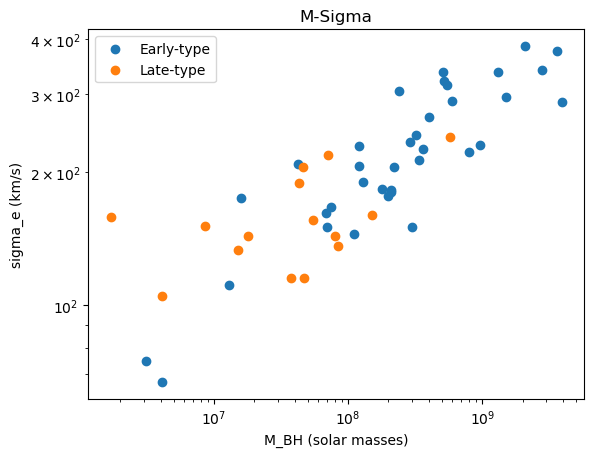

In [56]:
y="sigma_e (km/s)"
x="M_BH (solar masses)"

plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.xscale('log')
plt.yscale('log')
plt.title("M-Sigma")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)
plt.show()

The M-$\sigma$ relation, a linear in log-log-space relation between the mass of the central Supermassive Blach Hole and the velocity dispersion of the bulge stars. This relation holds for both early- and late-type galaxies.

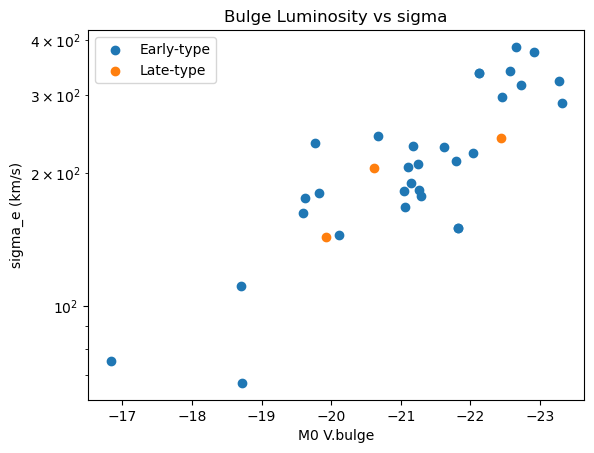

In [76]:
y="sigma_e (km/s)"
x="M0 V.bulge"


plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.yscale('log')
plt.gca().invert_xaxis()
plt.title("Bulge Luminosity vs sigma")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

plt.show()

Interestingly, there also seems to be a log-log-linear realtion between Bulge luminosity and Black Hole mass, though we only have enough data for early-type galaxies. 3 data points for late types is not enough to make statistical statements with any certainty.

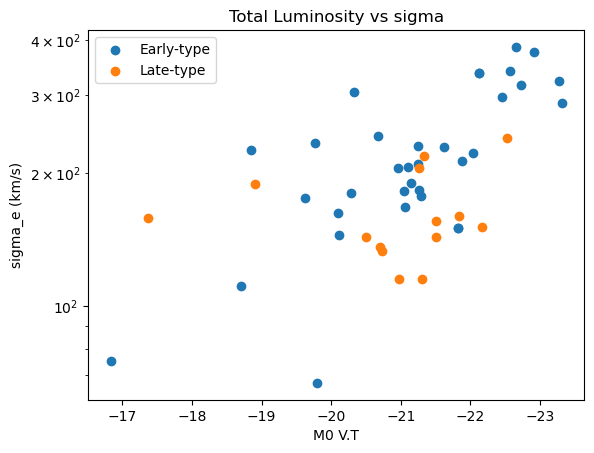

In [115]:
y="sigma_e (km/s)"
x="M0 V.T"


plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.yscale('log')
plt.gca().invert_xaxis()
plt.title("Total Luminosity vs sigma")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

plt.show()

Looking at the total luminosity versus the Blach Hole mass doesnt seem to have much correlation. The spread is way more pronounced than in the previous plots.

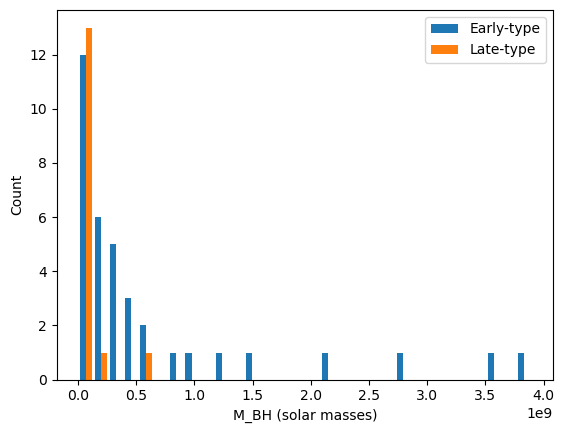

In [99]:
x = "M_BH (solar masses)"

plt.hist((early_type[x], late_type[x]), label = ("Early-type", "Late-type"), bins = 30)

plt.legend()
plt.xlabel(x)
plt.ylabel("Count")
plt.show()

A histogram of Black Hole masses, as can be seen, early-type galaxies have a very spread out distribution of BH masses, with a trailing off tail towards higher masses.

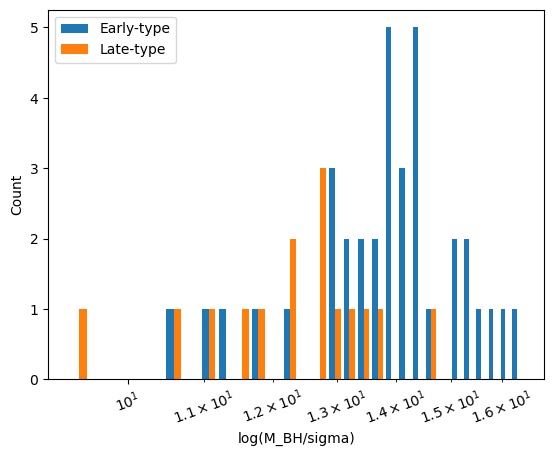

In [113]:
x = "M_BH (solar masses)"
y = "sigma_e (km/s)"

plt.hist((np.log(early_type[x]/early_type[y]), np.log(late_type[x]/late_type[y])), label = ("Early-type", "Late-type"), bins = 30)
plt.xscale("log")

plt.legend()
plt.tick_params(axis = "x", which = "both", labelrotation = 20)
plt.xlabel("log(M_BH/sigma)")
plt.ylabel("Count")
plt.show()

Taking a look at the distribution of Black Hole masses divided by $\sigma$, surprisingly the early-types almost look to be lognormal distributed. We havent yet checked wether they actually are in a lognormal distribution, nor do we know if this is physically relevant, but this definetly warrants a closer look.

54.598150033144236


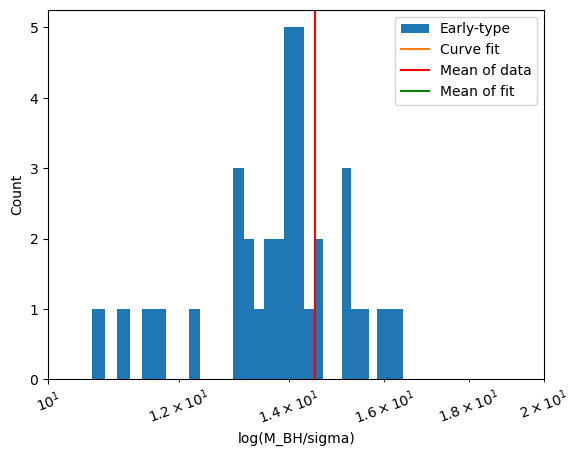

In [9]:
x = "M_BH (solar masses)"
y = "sigma_e (km/s)"
def logfunc(x, mu, sigma):
    return (1/((x)*np.sqrt(2*np.pi*(sigma**2))))*np.exp((-(np.log(x)-mu)**2)/(2*(sigma**2)))
bins = 30
plt.hist(np.log((early_type[x]/early_type[y])), label = "Early-type", bins = bins)
y_data, x_data = np.histogram((early_type[x]/early_type[y]), bins = bins) #This should not be a log, but the fit doesnt give me anything if it isnt
plt.xscale("log")
#print((y_data), (x_data))

popt, pcov = curve_fit(logfunc, x_data[:-1], y_data)
plt.plot((x_data), (logfunc(x_data, popt[0], popt[1])), label = "Curve fit")
plt.axvline(np.log(np.average(a = x_data[:-1], weights = y_data)), color = "r", label = "Mean of data")
plt.axvline(np.exp(popt[0]), color = "g", label = "Mean of fit")

#print(np.exp(2*popt[0]+(popt[1]**2))*(np.exp(popt[1])-1))
#print(np.exp(popt[1])**2)
print(np.exp(2*popt[0]+2*(popt[1]**2)))

plt.legend()
plt.tick_params(axis = "x", which = "both", labelrotation = 20)
plt.xlabel("log(M_BH/sigma)")
plt.ylabel("Count")
plt.xlim(10, 20)
plt.show()


Because fitting a lognormal function to the above distribution did not work, it seems likely that the data is not lognormal distributed, but merely appeared that way due to the chosen bin size of the histogram.

Mean of Data:  3.4929844904021953e-07
Variance of Data:  4.1944211211023353e-13
2-sigma confidence interval: (1.6792198817038843e-07, 5.306749099100506e-07)
5-sigma confidence interval: (-1.0414270313435821e-07, 8.027396012147973e-07)


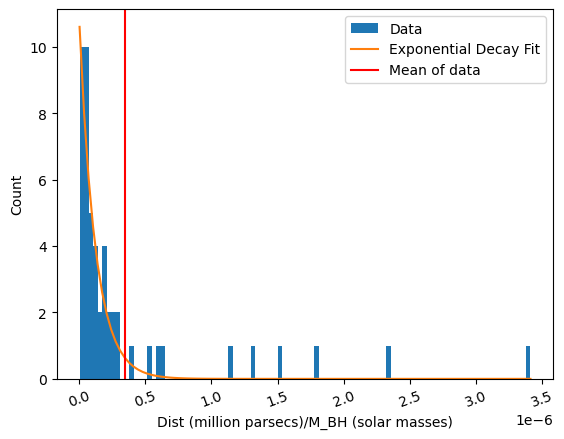

In [5]:
x = "Dist (million parsecs)"
y = "M_BH (solar masses)"

bins = 100

plt.hist((data[x]/data[y]), label = "Data", bins = bins)
y_data, x_data = np.histogram((data[x]/data[y]), bins = bins)

def exp_decay(x, N_0, lam):
    return N_0*np.exp(-lam*x)
popt, pcov = curve_fit(exp_decay, x_data[:-1], y_data)
plt.plot(x_data, exp_decay(x_data, popt[0], popt[1]), label = "Exponential Decay Fit")
#print(popt)

mean = np.sum(data[x]/data[y])/len(data[x]/data[y])
var = np.sum((data[x]/data[y])**2)/len(data[x]/data[y])-mean**2
print("Mean of Data: ", mean)
print("Variance of Data: ", var)
plt.axvline(mean, color = "r", label = "Mean of data")

two_sig_conf = (mean-2*(np.sqrt(var/len(data[x]/data[y]))), mean+2*(np.sqrt(var/len(data[x]/data[y]))))
five_sig_conf = (mean-5*(np.sqrt(var/len(data[x]/data[y]))), mean+5*(np.sqrt(var/len(data[x]/data[y]))))
print("2-sigma confidence interval for mean:", two_sig_conf)
print("5-sigma confidence interval for mean:", five_sig_conf)

plt.legend()
plt.tick_params(axis = "x", which = "both", labelrotation = 20)
plt.xlabel("Dist (million parsecs)/M_BH (solar masses)")
plt.ylabel("Count")
plt.show()

Distance over Black Hole mass almost certainly doesnt follow a physically relevant distribution, unless you look at Black Holes billions of parsecs away, as you would be looking into the early universe. It does however follow a instrument related distribution. To get good data of Black Holes far away, you need to look at bigger, and therefor more massive Black Holes. Distance/Black Hole mass should therefor be almost constant, and as can be seen in the distribution above, most values lie very close together, with only a few outliers to the left at higher distances compared to Black Hole mass. Additionally, as seen in the plots below, most of the data points for both distance and Blck Hole mass have similar values in the first place, so their combined quantitiy following the above distribution is expected.

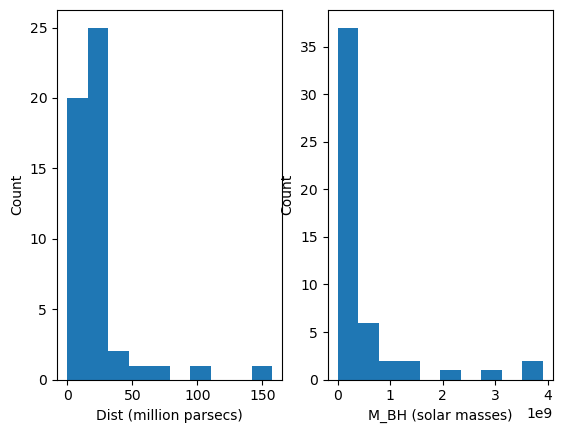

In [19]:
x = "Dist (million parsecs)"
y = "M_BH (solar masses)"

plt.subplot(121)
plt.hist(data[x])
plt.xlabel("Dist (million parsecs)")
plt.ylabel("Count")

plt.subplot(122)
plt.hist(data[y])
plt.xlabel("M_BH (solar masses)")
plt.ylabel("Count")

plt.show()

We have two Black Hole mass samples, one from our paper ($\mu_1) and one from the AGN catalog ($\mu_2). We test wether these samples have the same mean BH mass. \
$H_0$: $\mu_1 = \mu_2$ \
$H_a$: $\mu_1 \neq \mu_2$


Mean 1: 478674509.8039216
Mean 2: 82177926576.10056
Standard deviation 1: 1.4506499912505705e-12
Standard deviation 2: 0.0032173957755840792
t-value: -7526779491760023.0
95% COnfidence Interval: (-81699252066.29665, -81699252066.29662)


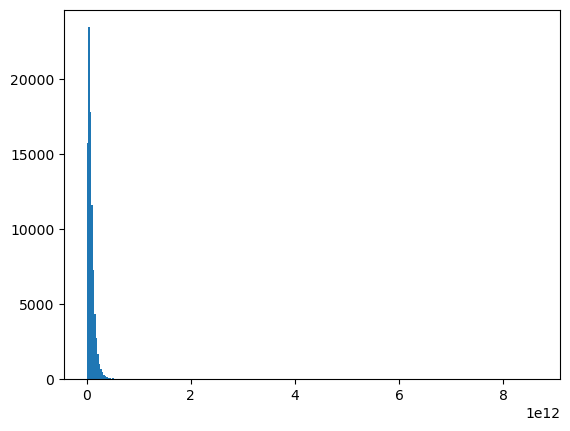

8661637419723.033


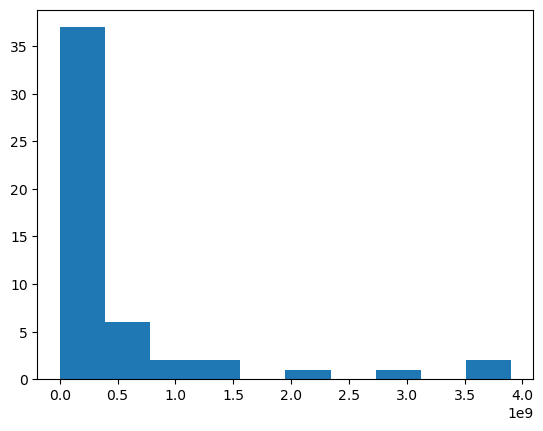

TtestResult(statistic=-275.3150391978492, pvalue=0.0, df=1831.6154563206233)

In [62]:
mbh = "M_BH (solar masses)"

# Means for both data sets
mean_data1 = np.sum(data[mbh])/len(data[mbh])
mean_data2 = np.sum(data_AGN_BH)/len(data_AGN_BH)


# Standard deviation for both data sets
std_data1 = (np.sum(data[mbh]-mean_data1))**2/(len(data[mbh]))**0.5
std_data2 = (np.sum(data_AGN_BH-mean_data2))**2/(len(data_AGN_BH))**0.5
print("Mean 1:", mean_data1)
print("Mean 2:", mean_data2)
print("Standard deviation 1:", std_data1)
print("Standard deviation 2:", std_data2)

# The t-value, for "case 2" in the lecture notes, large sample sizes with population standard deviations
T = (mean_data1 - mean_data2)/(np.sqrt(std_data1**2/len(data[mbh])+std_data2**2/len(data_AGN_BH)))
print("t-value:", T)

# 95% Confidence interval, has to contain 0 for means to not be different

lower = (mean_data1 - mean_data2)-1.96*np.sqrt((std_data1**2/len(data[mbh]))+(std_data2**2/len(data_AGN_BH)))
upper = (mean_data1 - mean_data2) + 1.96*np.sqrt((std_data1**2/len(data[mbh]))+(std_data2**2/len(data_AGN_BH)))
print("95% Confidence Interval:", (lower, upper))

plt.hist(data_AGN_BH, bins = 300)
plt.show()
print(max(data_AGN_BH))
plt.hist(data[mbh])
plt.show()

ttest_ind(data[mbh], data_AGN_BH, equal_var = False)

As it turns out, the two means of these samples are so far apart, our p-value is zero, and our 95% confidence interval is 11 orders of magnitude away from zero.